In [17]:
import networkx as nx
import csv
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from node2vec import Node2Vec
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.decomposition import PCA

#### Creating a networkx graph from the csv file

In [18]:
G = nx.DiGraph()

with open('../data/Iron_dealers_data.csv', 'r') as f:
    reader = csv.reader(f)
    for index, row in enumerate(reader):
        if index == 0:
            continue
        src, dest, amount = int(row[0]), int(row[1]), float(row[2])
        e = (src, dest)
        if G.has_edge(*e):
            G[src][dest]['frequency'] += 1
            G[src][dest]['amount'] += amount
        else:
            G.add_edge(src, dest, frequency=1, amount=0,r=[False, False, False, False])

            # r is bit vector to see if edge is the part of a 3-cycle with 0, 1, 2, 3 reciprocal edges
print(G)

DiGraph with 799 nodes and 5358 edges


In [19]:
def set_bit_on_edge(src, dest, number_of_reciprocal_edges):

    if G.has_edge(src, dest):
        G[src][dest]['r'][number_of_reciprocal_edges] = True

def count_reciprocal_edges(node1, node2, node3):
    cycle_1_2 = [0, 0, 0]
    cycle_2_1 = [0, 0, 0]

    if G.has_edge(node1, node2):
        cycle_1_2[0] = 1
    if G.has_edge(node2, node1):
        cycle_2_1[0] = 1
    if G.has_edge(node2, node3):
        cycle_1_2[1] = 1
    if G.has_edge(node3, node2):
        cycle_2_1[1] = 1
    if G.has_edge(node3, node1):
        cycle_1_2[2] = 1
    if G.has_edge(node1, node3):
        cycle_2_1[2] = 1

    is_cycle = False
    if cycle_1_2 == [1, 1, 1] or cycle_2_1 == [1, 1, 1]:
        is_cycle = True

    if not is_cycle:
        return
    
    # Number of reciprocal edges
    cycle = [c12 * c21 for c12, c21 in zip(cycle_1_2, cycle_2_1)]
    number_of_reciprocal_edges = sum(cycle) # 0, 1, 2 or 3
    assert number_of_reciprocal_edges >= 0 and number_of_reciprocal_edges <= 3 
    
    # Assign bit vector
    set_bit_on_edge(node1, node2, number_of_reciprocal_edges)

In [20]:
def get_in_out_neighbours(node):
    return list(set(list(list(G.predecessors(node)) + list(G.successors(node)))))

for edge in tqdm(G.edges(data=False)):
    common_neighbours = list(set(get_in_out_neighbours(edge[0]) + get_in_out_neighbours(edge[1])))
    common_neighbours = [neigh for neigh in common_neighbours if neigh != edge[0] and neigh != edge[1]]
    
    for node in common_neighbours:
        count_reciprocal_edges(edge[0], edge[1], node)

100%|██████████| 5358/5358 [00:00<00:00, 7510.30it/s]


#### Assign weights to edges from the bit vector

In [21]:
for edge in G.edges(data=True):
    src, dest = edge[0], edge[1]
    weight = ((3 - G[src][dest]['r'][::-1].index(True)) if True in G[src][dest]['r'] else -1) + 1 # 0, 1, 2, 3 or 4
    ''' 
    From the community detection paper:
    0 -> 1
    1 -> 2
    2 -> 3
    3 -> 3
    4 -> 4
    '''
    if weight == 1 or weight == 2:
        weight += 1
    elif weight == 0:
        weight = 1
    G.add_edge(src, dest, weight=weight)

In [22]:
# for edge in G.edges(data=True):
#     print(edge)

#### Create the undirected graph

In [23]:
G_undirected = nx.Graph()
for edge in G.edges(data=True):
    weight = G[edge[0]][edge[1]]['weight']
    frequency = G[edge[0]][edge[1]]['frequency']
    if G.has_edge(edge[1], edge[0]):
        weight = max(weight, G[edge[1]][edge[0]]['weight'])
        frequency += G[edge[1]][edge[0]]['frequency']
    
    frequency_factor = frequency // 2647
    if frequency_factor == 0:
        frequency_factor = 1
    assert frequency_factor >= 1
    frequency_factor = 1
    G_undirected.add_edge(edge[0], edge[1], weight=weight * ( frequency_factor ))

print(G_undirected)

Graph with 799 nodes and 5040 edges


In [24]:
node2vec = Node2Vec(G_undirected, dimensions=32, walk_length=10, num_walks=200, workers=8, weight_key='weight') 
print("Constructor init done. Fit now")
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

Generating walks (CPU: 8): 100%|██████████| 25/25 [00:01<00:00, 13.88it/s]


Constructor init done. Fit now


In [25]:
model.wv.save_word2vec_format("node_embeddings.txt")
model.save("model.txt")

In [26]:
input = np.array([model.wv[str(node)] for node in G_undirected.nodes()])
print(input.shape)

(799, 32)


In [75]:
# eps = 1, min_samples = 5, 6
# eps = 1.5

eps = 1
min_samples = 5

clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(input)
print("Number of core samples: ", len(clustering.core_sample_indices_))
print("Number of clusters: ", len(list(set(clustering.labels_))))

Number of core samples:  31
Number of clusters:  10


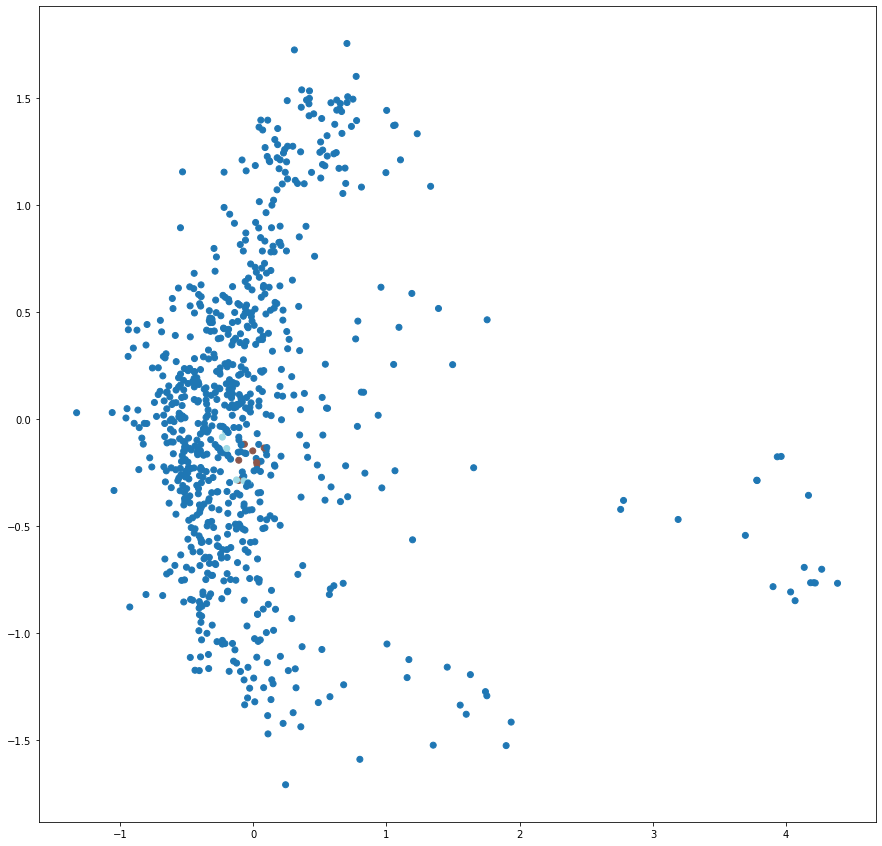

In [57]:
pca = PCA(n_components=2).fit(input)
input_red = pca.transform(input)

fig, ax = plt.subplots(figsize=(15, 15))
plt.scatter(input_red[:, 0], input_red[:, 1], c=[_ + 1 for _ in clustering.labels_], cmap='tab20')

In [58]:
nodes = list(G_undirected.nodes())
label_to_node = {}
for index, label in enumerate(clustering.labels_):
    if label not in label_to_node:
        label_to_node[label] = [nodes[index]]
    else:
        label_to_node[label].append(nodes[index])

In [59]:
for key in label_to_node.keys():
    if key == -1:
        continue
    print(key, len(label_to_node[key]))

1 6
0 7


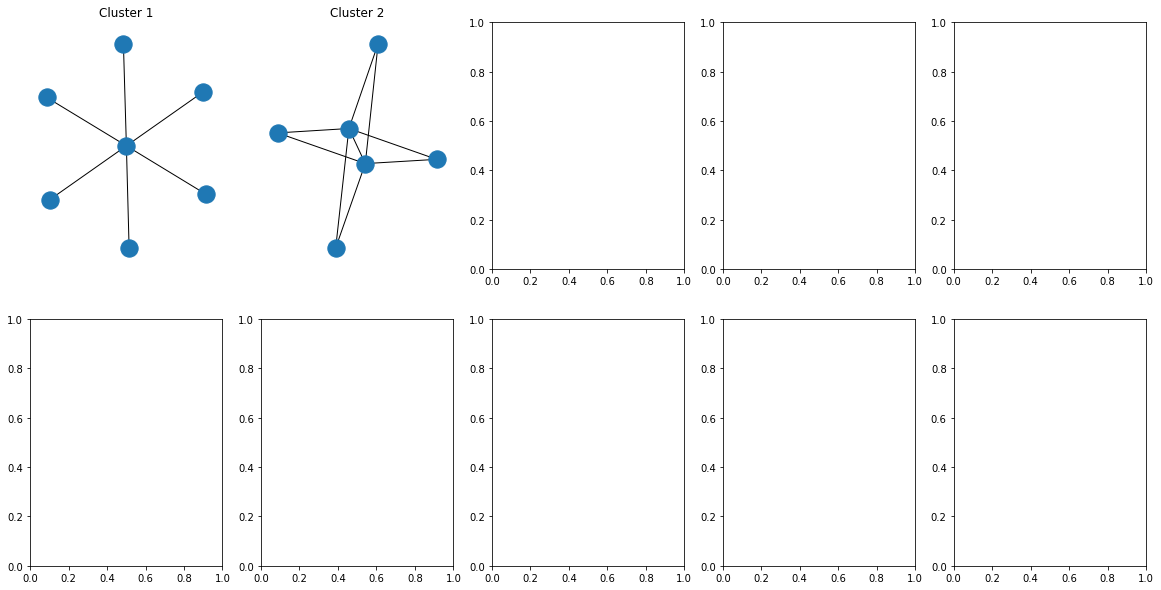

In [72]:
nrows = 2
ncols = 5

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

for i in range(nrows):
    for j in range(ncols):
        index = i * ncols + j
        if index >= len(label_to_node.keys()) - 1:
            break
        nx.draw(G_undirected.subgraph(label_to_node[index]), ax=axes[i][j])
        axes[i][j].set_title(f'Cluster {index + 1}')